# Kapitel 2: Extrahieren von Einblicken in Texten mit APIs

## Setup<div class='tocSkip'/>

Es werden die Verzeichnisse festgelegt. Wenn Sie mit Google Colab arbeiten: Die erforderlichen Dateien werden kopiert und die erforderlichen Bibliotheken installiert.

## Hinweis

Mit ### ergänzte Code-Zeilen geben Werte an, die angepasst werden können.

Sie benötigen einen Twitter-Account mit Developer-Rechten.

ACHTUNG: Wenn Sie häufig auf GITHUB zugreifen (z.B. beim Debuggen), dann wir der Zugriff auf GITHUB temporär verweigert udn es kann zu langen Wartezeiten kommen.

### ÄNDERN SIE DIE BEIDEN DATUMSANGABEN UNTEN!!!

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch02/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".

Additional setup (may take a few minutes) ...
!pip install -r requirements.txt
!python -m nltk.downloader stopwords


## Python-Einstellungen laden

Allgemeine Importe, Standardwerte für die Formatierung in Matplotlib, Pandas usw.

In [2]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# Ausgabe aller Anweisungen und nicht nur der letzten
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# sonst wird der Text zwischen den $-Zeichen als Formel interpretiert und kursiv gedruckt
pd.set_option('display.html.use_mathjax', False)

# Pfad zum Importieren von Packages der Blueprints
sys.path.append(BASE_DIR + '/packages')

In [3]:
# adjust matplotlib resolution for book version
matplotlib.rcParams.update({'figure.dpi': 200 })

# 1. Blueprint: Extrahieren von Daten aus einer API mithilfe des Request-Moduls

In [4]:
import requests

response = requests.get('https://api.github.com/repositories',
                        headers={'Accept': 'application/vnd.github.v3+json'})
print(response.status_code)

200


In [5]:
print (response.encoding)
print (response.headers['Content-Type'])
print (response.headers['server'])

utf-8
application/json; charset=utf-8
GitHub.com


In [6]:
response.headers

{'Server': 'GitHub.com', 'Date': 'Sat, 05 Mar 2022 09:38:20 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Cache-Control': 'public, max-age=60, s-maxage=60', 'Vary': 'Accept, Accept-Encoding, Accept, X-Requested-With', 'ETag': 'W/"3b08785a912fd9158abc75739a1173520f25f493467dd3eaef5d02674b84ca0f"', 'X-GitHub-Media-Type': 'github.v3; format=json', 'Link': '<https://api.github.com/repositories?since=369>; rel="next", <https://api.github.com/repositories{?since}>; rel="first"', 'Access-Control-Expose-Headers': 'ETag, Link, Location, Retry-After, X-GitHub-OTP, X-RateLimit-Limit, X-RateLimit-Remaining, X-RateLimit-Used, X-RateLimit-Resource, X-RateLimit-Reset, X-OAuth-Scopes, X-Accepted-OAuth-Scopes, X-Poll-Interval, X-GitHub-Media-Type, X-GitHub-SSO, X-GitHub-Request-Id, Deprecation, Sunset', 'Access-Control-Allow-Origin': '*', 'Strict-Transport-Security': 'max-age=31536000; includeSubdomains; preload', 'X-Frame-Options': 'deny', 'X-Content-Type-Options': 'nosniff', 'X-XSS-Protec

In [7]:
import json
print (json.dumps(response.json()[0], indent=2)[:200])

{
  "id": 1,
  "node_id": "MDEwOlJlcG9zaXRvcnkx",
  "name": "grit",
  "full_name": "mojombo/grit",
  "private": false,
  "owner": {
    "login": "mojombo",
    "id": 1,
    "node_id": "MDQ6VXNlcjE=",



In [8]:
response = requests.get('https://api.github.com/search/repositories')
print (response.status_code)

422


In [9]:
response = requests.get('https://api.github.com/search/repositories',
    params={'q': 'data_science+language:python'},
    headers={'Accept': 'application/vnd.github.v3.text-match+json'})


print(response.status_code)

200


In [10]:
from IPython.display import Markdown, display  ###
def printmd(string):  ###
    display(Markdown(string))  ###
    
for item in response.json()['items'][:5]:
    printmd('**' + item['name'] + '**' + ': repository ' +
            item['text_matches'][0]['property'] + ' - \"*' +
            item['text_matches'][0]['fragment'] + '*\" matched with ' + '**' +
            item['text_matches'][0]['matches'][0]['text'] + '**')

**data-science-from-scratch**: repository description - "*code for Data Science From Scratch book*" matched with **Data Science**

**data-science-blogs**: repository description - "*A curated list of data science blogs*" matched with **data science**

**galaxy**: repository description - "*Data intensive science for everyone.*" matched with **Data**

**data-scientist-roadmap**: repository description - "*Toturials coming with the "data science roadmap" picture.*" matched with **data science**

**DataCamp**: repository description - "*DataCamp data-science courses*" matched with **data**

In [11]:
response = requests.get(
    'https://api.github.com/repos/pytorch/pytorch/issues/comments')

print('Response Code', response.status_code)
print('Number of comments', len(response.json()))

Response Code 200
Number of comments 30


In [12]:
response.links

{'next': {'url': 'https://api.github.com/repositories/65600975/issues/comments?page=2',
  'rel': 'next'},
 'last': {'url': 'https://api.github.com/repositories/65600975/issues/comments?page=1334',
  'rel': 'last'}}

In [13]:
def get_all_pages(url, params=None, headers=None):
    output_json = []
    response = requests.get(url, params=params, headers=headers)
    if response.status_code == 200:
        output_json = response.json()
        if 'next' in response.links:
            next_url = response.links['next']['url']
            if next_url is not None:
                output_json += get_all_pages(next_url, params, headers)
    return output_json


out = get_all_pages(
    "https://api.github.com/repos/pytorch/pytorch/issues/comments",
    params={
        'since': '2022-03-04T20:00:00Z', ### Datum anpassen, sonst werden zu viele Daten geliefert
        'sorted': 'created',
        'direction': 'desc'
    },
    headers={'Accept': 'application/vnd.github.v3+json'})

df = pd.DataFrame(out)

In [14]:
pd.set_option('display.max_colwidth', -1) ###
print (df['body'].count())
df[['id','created_at','body']].sample(5, random_state=11) ###

155


id            created_at  \
119  1058593780  2022-03-03T22:49:56Z   
137  1055756243  2022-03-01T18:58:27Z   
126  1057451966  2022-03-02T22:19:03Z   
65   1059588460  2022-03-04T22:53:12Z   
88   1059532773  2022-03-04T21:10:13Z   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [15]:
response = requests.head(
    'https://api.github.com/repos/pytorch/pytorch/issues/comments')
print('X-Ratelimit-Limit', response.headers['X-Ratelimit-Limit'])
print('X-Ratelimit-Remaining', response.headers['X-Ratelimit-Remaining'])

# Umwandlung der UTC-Zeit in ein für Menschen lesbares Format
import datetime
print(
    'Rate Limits reset at',
    datetime.datetime.fromtimestamp(int(
        response.headers['X-RateLimit-Reset'])).strftime('%c'))

X-Ratelimit-Limit 60
X-Ratelimit-Remaining 42
Rate Limits reset at Sat Mar  5 11:33:55 2022


In [16]:
from datetime import datetime
import time

def handle_rate_limits(response):
    now = datetime.now()
    reset_time = datetime.fromtimestamp(
        int(response.headers['X-RateLimit-Reset']))
    remaining_requests = response.headers['X-Ratelimit-Remaining']
    remaining_time = (reset_time - now).total_seconds()
    intervals = remaining_time / (1.0 + int(remaining_requests))
    print('Sleeping for', intervals)
    time.sleep(intervals)
    return True

In [17]:
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

retry_strategy = Retry(
    total=5,
    status_forcelist=[500, 503, 504],
    backoff_factor=1
)

retry_adapter = HTTPAdapter(max_retries=retry_strategy)

http = requests.Session()
http.mount("https://", retry_adapter)
http.mount("http://", retry_adapter)

response = http.get('https://api.github.com/search/repositories',
                   params={'q': 'data_science+language:python'})

for item in response.json()['items'][:10]:
    print (item['name'])

data-science-from-scratch
data-science-blogs
galaxy
data-scientist-roadmap
DataCamp
dsp
Kaggler
cookiecutter-data-science
PDA_Book
book_sample


In [18]:
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

retry_strategy = Retry(
    total=5,
    status_forcelist=[500, 503, 504],
    backoff_factor=1
)

retry_adapter = HTTPAdapter(max_retries=retry_strategy)

http = requests.Session()
http.mount("https://", retry_adapter)
http.mount("http://", retry_adapter)


def get_all_pages(url, param=None, header=None):
    output_json = []
    response = http.get(url, params=param, headers=header)

    if response.status_code == 200:
        output_json = response.json()
        if 'next' in response.links:
            next_url = response.links['next']['url']
            if (next_url is not None) and (handle_rate_limits(response)): 
                output_json += get_all_pages(next_url, param, header)
    return output_json

In [19]:
### Datum anpassen, sonst werden zu viele Daten geliefert
out = get_all_pages("https://api.github.com/repos/pytorch/pytorch/issues/comments", 
                    param={'since': '2022-03-04T20:00:00Z'})

df = pd.DataFrame(out)

Sleeping for 79.0856535952381
Sleeping for 79.07541497560975
Sleeping for 79.065107525
Sleeping for 79.05382515384615
Sleeping for 79.04345202631579


# Blueprint - Extracting Twitter data with Tweepy

In [20]:
import tweepy

#app_api_key = 'YOUR_APP_KEY_HERE' 
#app_api_secret_key = 'YOUR_APP_SECRET_HERE'
app_api_key = 'i8blowOQsEiTd7A3fh5edxc2d' 
app_api_secret_key = 'uBzbGdnp3mvTjCJm5k5tHHdyW3TIX8n0atAHxcYJzA75ANkB9p'

auth = tweepy.AppAuthHandler(app_api_key, app_api_secret_key)
api = tweepy.API(auth)

print(api)

print ('API Host', api.host)


API Host api.twitter.com


In [21]:
pd.set_option('display.max_colwidth', None) ###
search_term = 'cryptocurrency'

tweets = tweepy.Cursor(api.search_tweets,
                       q=search_term,
                       lang="en").items(100)

retrieved_tweets = [tweet._json for tweet in tweets]
df = pd.json_normalize(retrieved_tweets)

df[['text']].sample(3)

,text
85,"RT @NoVa_BTL: The high coveted Token in the NoVa Battles Universe..🌌\n\nNVA 🚀🌑\n\nJoin our pre-launch airdrop!📃 1,000,000 NVA Tokens up for gra…"
13,"RT @BTCTN: ""It is an open ledger, trying to sneak lots of money through #crypto would be more traceable than using U.S. dollars cash, art,…"
35,RT @RTRcrypto: $FEG's $FBNB contract is now the number 27 holder of #BNB!\n\n@cz_binance take a look\n🦍\n\n@FEGtoken\n\n#BSC #BSCGems #BinanceSmar…


In [22]:
api = tweepy.API(auth,
                 wait_on_rate_limit=True,
                 retry_count=5,
                 retry_delay=10)

search_term = 'cryptocurrency OR crypto -filter:retweets'

tweets = tweepy.Cursor(api.search_tweets,
                       q=search_term,
                       lang="en",
                       tweet_mode='extended',
                       count=30).items(100)

retrieved_tweets = [tweet._json for tweet in tweets]

df = pd.json_normalize(retrieved_tweets)
print('Number of retrieved tweets ', len(df))

Number of retrieved tweets  100


In [23]:
df[['created_at','full_text','entities.hashtags']].sample(5)

,created_at,full_text,entities.hashtags
56,Sat Mar 05 09:44:52 +0000 2022,#Crypto #ANC - The Anchor Protocol price is currently $5.33 with a 24-hour trading volume of $245.43M across 13 exchanges. The ANC price is up 13.61% in the last 24 hours. The Anchor Protocol price prediction sentiment is currently bullish.\nhttps://t.co/vLectGW3QN,"[{'text': 'Crypto', 'indices': [0, 7]}, {'text': 'ANC', 'indices': [8, 12]}]"
81,Sat Mar 05 09:44:37 +0000 2022,This is a very interesting platform and Valerstudios give us a lot of benefit so guys don't miss this wonderful opportunity this is a great chance for joining Be a part of this platform. \n#Valerstudios #VLR #blockchain #cryptocurrency #cryptocurrencies #fintech,"[{'text': 'Valerstudios', 'indices': [188, 201]}, {'text': 'VLR', 'indices': [202, 206]}, {'text': 'blockchain', 'indices': [207, 218]}, {'text': 'cryptocurrency', 'indices': [219, 234]}, {'text': 'cryptocurrencies', 'indices': [236, 253]}, {'text': 'fintech', 'indices': [254, 262]}]"
96,Sat Mar 05 09:44:29 +0000 2022,@KOmonigho @PiHub_Utility @PiCoreTeam Mate along will pi I suggest you to use PUNK PANDA app. It is available in Playstore. It rewards you with free crypto every 30 mins. More importantly it's value is 1.0875$ already and hits 1.25$ by March according to community. Use my referral if you need one 938332,[]
87,Sat Mar 05 09:44:34 +0000 2022,Crypto is simply this easy: Buy as much as Bitcoin as you possibly can over the next decade and keep it locked away in cold storage. Everything else is just noise. Stop trying to get rich overnight and you’ll definitely be rich in a decade.,[]
97,Sat Mar 05 09:44:29 +0000 2022,@cym_token A lot of potential advantages in Cryptocurrency and Blockchain technology. CYM Token offers you financial freedom ! #cymtoken #cymarmy LET’S GO ! 🔥💥🚀🌙,"[{'text': 'cymtoken', 'indices': [128, 137]}, {'text': 'cymarmy', 'indices': [138, 146]}]"


In [24]:
def extract_entities(entity_list):
    entities = set()
    if len(entity_list) != 0:
        for item in entity_list:
            for key,value in item.items():
                if key == 'text':
                    entities.add(value.lower())
    return list(entities)

<AxesSubplot:>

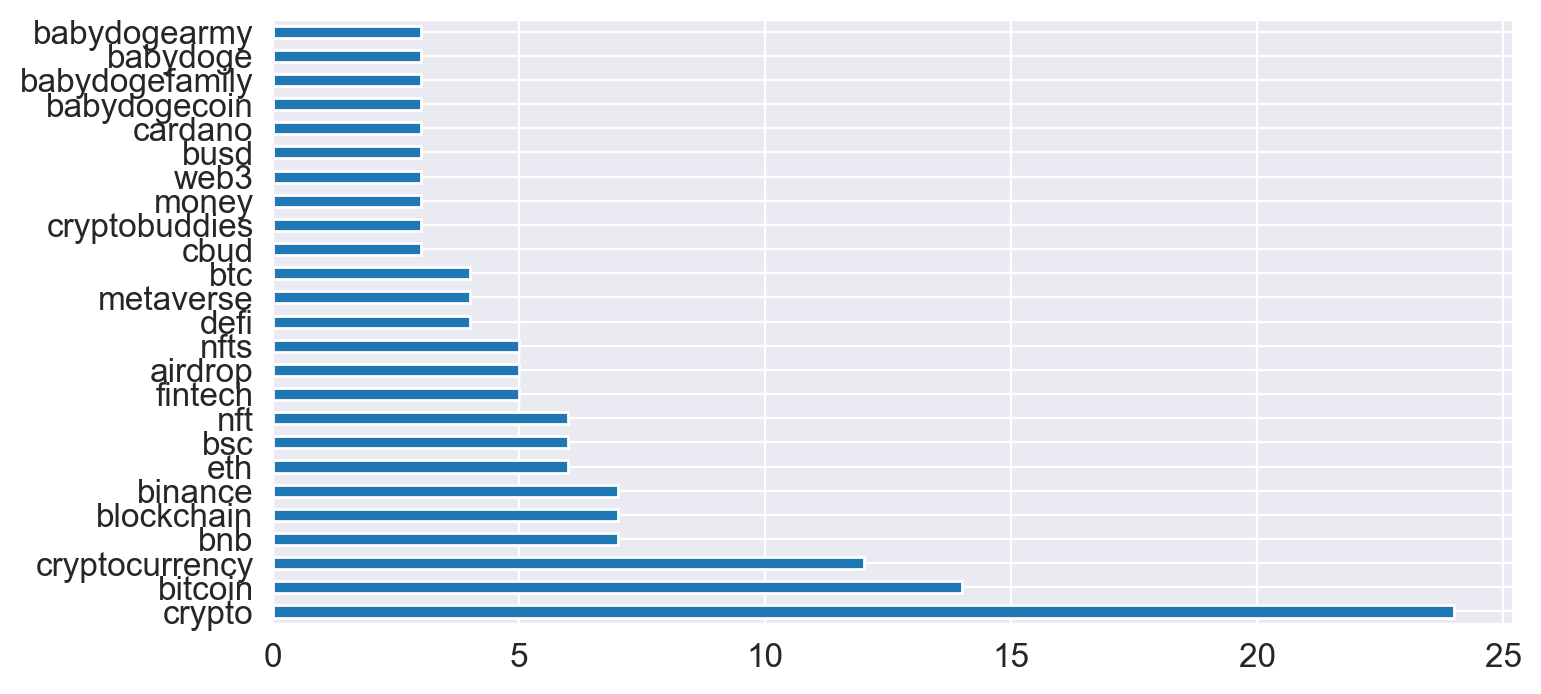

In [25]:
df['Entities'] = df['entities.hashtags'].apply(extract_entities)
pd.Series(np.concatenate(df['Entities'])).value_counts()[:25].plot(kind='barh')

In [26]:
api = tweepy.API(auth, wait_on_rate_limit=True)

tweets = tweepy.Cursor(api.user_timeline,
                       screen_name='MercedesAMGF1',
                       tweet_mode='extended',
                       count=30).items(100) ###

retrieved_tweets = [tweet._json for tweet in tweets]
df = pd.io.json.json_normalize(retrieved_tweets)
print ('Number of retrieved tweets ', len(df))

Number of retrieved tweets  100


In [27]:
def get_user_timeline(screen_name):
    api = tweepy.API(auth,
                     wait_on_rate_limit=True,)
    tweets = tweepy.Cursor(api.user_timeline,
                           screen_name=screen_name,
                           tweet_mode='extended',
                           count=20).items() ### Original items()
    retrieved_tweets = [tweet._json for tweet in tweets]
    df = pd.io.json.json_normalize(retrieved_tweets)
    df = df[~df['retweeted_status.id'].isna()]
    return df

In [28]:
### Achtung! Die Verarbeitung dauert etwas!

df_mercedes = get_user_timeline('MercedesAMGF1')
print ('Number of Tweets from Mercedes', len(df_mercedes))
df_ferrari = get_user_timeline('ScuderiaFerrari')
print ('Number of Tweets from Ferrari', len(df_ferrari))

Number of Tweets from Mercedes 125
Number of Tweets from Ferrari 47


In [29]:
import regex as re
import nltk
from collections import Counter
from wordcloud import WordCloud

stopwords = set(nltk.corpus.stopwords.words('english'))
RE_LETTER = re.compile(r'\b\p{L}{2,}\b')

def tokenize(text):
    return RE_LETTER.findall(text)

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # Token verarbeiten und Zähler aktualisieren
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # Zähler erstellen und alle Daten durchlaufen
    counter = Counter()
    df[column].map(update)

    # Zähler umwandeln in ein Data Frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # Data Frame in Dictionary umwandeln
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # Stoppwörter im Frequenzzähler filtern
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [30]:
def wordcloud_blueprint(df, colName, max_words, num_stopwords):
    # Schritt 1: Spalte der Eingabetexte in Token umwandeln
    df['tokens'] = df[colName].map(prepare)
    
    # Schritt 2: Häufigkeit jedes Tokens bestimmen
    freq_df = count_words(df)
    
    # Schritt 3: Word Cloud mit Hilfe der Häufigkeiten, die für Stoppwörter kontrolliert werden, erstellen
    wordcloud(freq_df['freq'], max_words, stopwords=freq_df.head(num_stopwords).index)

<Figure size 2400x800 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

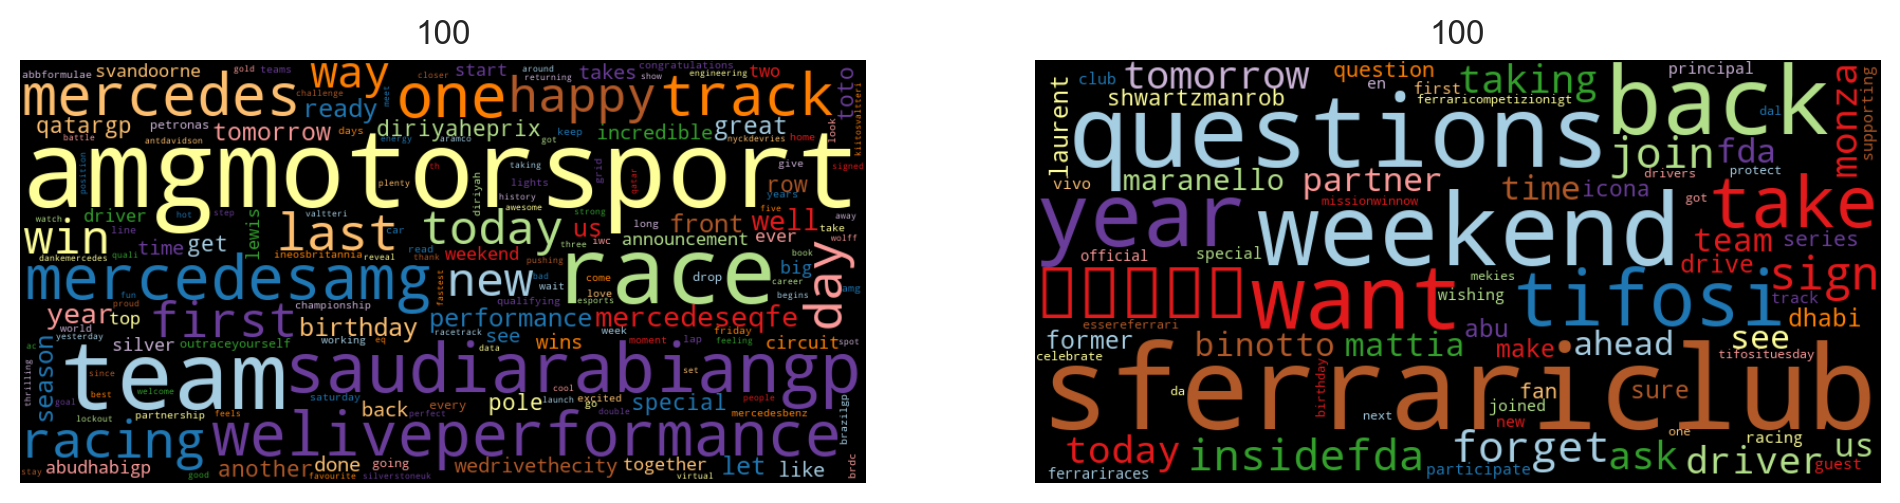

In [31]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)  ###
wordcloud_blueprint(df_mercedes, 'full_text',
          max_words=100,
          num_stopwords=5)

plt.subplot(1, 2, 2)  ###
wordcloud_blueprint(df_ferrari, 'full_text',
          max_words=100,
          num_stopwords=5)

In [32]:
access_token = '1483782427554234371-TtVEjYdPHgeWJogO0iVnq5ryv19nf9'
access_token_secret = 'Z3MaGnhEOPxg763lSbMK8BowCr7jV8YwBIRcutVFoj0Gy'

#Consumer Key entspricht API Key 
consumer_key = 'i8blowOQsEiTd7A3fh5edxc2d'
consumer_secret = 'uBzbGdnp3mvTjCJm5k5tHHdyW3TIX8n0atAHxcYJzA75ANkB9p'

class FileStreamListener(tweepy.Stream):
    def on_data(self, data):
        self.tweets = []
        i=0
        max_tweets = 5
        while (i < max_tweets):
            i+=1
            self.tweets.append(json.loads(data))
            print(i,"-ter Tweets wird geholt", sep="")
        filename = 'Tweets_' + str(datetime.now().time().strftime("%H%M%S%f")) + '.txt'
        print ('Tweets saved to', filename)
        file = open(filename, "w")
        json.dump(self.tweets, file)
        file.close()
        # Stream wird geschlossen
        self.disconnect()
#        return filename

    def on_status(self, status):
        print(status.id)
        print(status.text)
        return False
    
fsl = FileStreamListener(consumer_key,consumer_secret,access_token,access_token_secret)
#fsl.filter(track=['cryptocurrency'])
fsl.filter(track=['Trump'])


Stream connection closed by Twitter


1-ter Tweets wird geholt
2-ter Tweets wird geholt
3-ter Tweets wird geholt
4-ter Tweets wird geholt
5-ter Tweets wird geholt
Tweets saved to Tweets_104634102434.txt


In [33]:
df = pd.json_normalize(json.load(open('Tweets_103157245068.txt')))
df.head(3)

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,geo,coordinates,place,contributors,...,retweeted_status.reply_count,retweeted_status.retweet_count,retweeted_status.favorite_count,retweeted_status.entities.hashtags,retweeted_status.entities.urls,retweeted_status.entities.user_mentions,retweeted_status.entities.symbols,retweeted_status.favorited,retweeted_status.retweeted,retweeted_status.filter_level,retweeted_status.lang,entities.hashtags,entities.urls,entities.user_mentions,entities.symbols
0,Wed Feb 02 09:31:52 +0000 2022,1488807368825753600,1488807368825753600,RT @amyklobuchar: Now it comes out Trump was making calls to security officials after he lost to have VOTING MACHINES seized. They refused.…,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,None,None,None,None,None,None,None,None,None,...,1158,6332,33126,[],"[{'url': 'https://t.co/yygCWmsTyV', 'expanded_url': 'https://twitter.com/i/web/status/1488540352709599235', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",[],[],False,False,low,en,[],[],"[{'screen_name': 'amyklobuchar', 'name': 'Amy Klobuchar', 'id': 33537967, 'id_str': '33537967', 'indices': [3, 16]}]",[]
1,Wed Feb 02 09:31:52 +0000 2022,1488807368825753600,1488807368825753600,RT @amyklobuchar: Now it comes out Trump was making calls to security officials after he lost to have VOTING MACHINES seized. They refused.…,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,None,None,None,None,None,None,None,None,None,...,1158,6332,33126,[],"[{'url': 'https://t.co/yygCWmsTyV', 'expanded_url': 'https://twitter.com/i/web/status/1488540352709599235', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",[],[],False,False,low,en,[],[],"[{'screen_name': 'amyklobuchar', 'name': 'Amy Klobuchar', 'id': 33537967, 'id_str': '33537967', 'indices': [3, 16]}]",[]
2,Wed Feb 02 09:31:52 +0000 2022,1488807368825753600,1488807368825753600,RT @amyklobuchar: Now it comes out Trump was making calls to security officials after he lost to have VOTING MACHINES seized. They refused.…,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,None,None,None,None,None,None,None,None,None,...,1158,6332,33126,[],"[{'url': 'https://t.co/yygCWmsTyV', 'expanded_url': 'https://twitter.com/i/web/status/1488540352709599235', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]",[],[],False,False,low,en,[],[],"[{'screen_name': 'amyklobuchar', 'name': 'Amy Klobuchar', 'id': 33537967, 'id_str': '33537967', 'indices': [3, 16]}]",[]


In [34]:
import wikipediaapi

wiki_wiki = wikipediaapi.Wikipedia(
        language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI
)

p_wiki = wiki_wiki.page('Cryptocurrency')
print (p_wiki.text[:2000], '....') ###

A cryptocurrency, crypto-currency, or crypto is a digital currency designed to work as a medium of exchange through a computer network that is not reliant on any central authority, such as a government or bank, to uphold or maintain it.
Individual coin ownership records are stored in a digital ledger, which is a computerized database using strong cryptography to secure transaction records, to control the creation of additional coins, and to verify the transfer of coin ownership. Despite their name, cryptocurrencies are not necessarily considered to be currencies in the traditional sense and while varying categorical treatments have been applied to them, including classification as commodities, securities, as well as currencies, cryptocurrencies are generally viewed as a distinct asset class in practice. Some crypto schemes use validators to maintain the cryptocurrency. In a proof-of-stake model, owners put up their tokens as collateral. In return, they get authority over the token in p